In [200]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE

In [201]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'AAPL'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX','WILLIAMS','OBV']
ROWS_TO_PREDICT = 128
# one day 16 rows of data

In [202]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data
data.to_csv(f'../data/preprocess/APPLE_{ datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv', index=False)

[*********************100%***********************]  1 of 1 completed


In [203]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-03-23 04:00:00-04:00,56.220000,56.220000,55.500000,55.600000,55.600000,0
2020-03-23 05:00:00-04:00,55.550000,56.095000,55.370000,55.700000,55.700000,0
2020-03-23 06:00:00-04:00,56.032500,56.437500,55.937500,56.247500,56.247500,0
2020-03-23 07:00:00-04:00,56.132500,56.750000,56.042500,56.595000,56.595000,0
2020-03-23 08:00:00-04:00,56.550000,58.197500,55.625000,57.812500,57.812500,0
2020-03-23 09:00:00-04:00,57.837500,59.525000,56.887500,57.020000,57.020000,0
2020-03-23 09:30:00-04:00,56.299999,56.750000,54.823750,55.450001,55.450001,21473989
2020-03-23 10:30:00-04:00,55.465000,55.889999,53.412498,53.767502,53.767502,11306818
2020-03-23 11:30:00-04:00,53.762501,55.097500,53.152500,54.803925,54.803925,11355189


<AxesSubplot:xlabel='Datetime'>

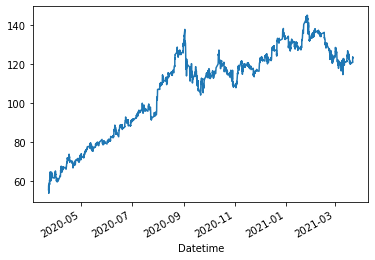

In [204]:
data['close'].plot()

In [205]:
data['close_pct'] = data['close'].pct_change();
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2020-03-23 04:00:00-04:00,56.2200,56.2200,55.5000,55.6000,55.6000,0,NaN
2020-03-23 05:00:00-04:00,55.5500,56.0950,55.3700,55.7000,55.7000,0,0.001799
2020-03-23 06:00:00-04:00,56.0325,56.4375,55.9375,56.2475,56.2475,0,0.009829
2020-03-23 07:00:00-04:00,56.1325,56.7500,56.0425,56.5950,56.5950,0,0.006178
2020-03-23 08:00:00-04:00,56.5500,58.1975,55.6250,57.8125,57.8125,0,0.021513


In [206]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4.184000e+03,4183.000000
mean,106.647825,107.170705,106.050904,106.648910,106.648910,4.712896e+06,0.000208
std,22.416630,23.118204,22.316115,22.400804,22.400804,8.306687e+06,0.005947
min,53.762501,55.097500,50.978220,53.767502,53.767502,0.000000e+00,-0.051319
25%,88.079375,88.343750,87.816876,88.091250,88.091250,0.000000e+00,-0.002031
50%,114.907500,115.243150,114.210000,114.900050,114.900050,0.000000e+00,0.000165
75%,123.512501,124.200000,122.819998,123.481253,123.481253,7.035310e+06,0.002525
max,144.900000,438.440000,144.590000,144.910000,144.910000,9.845401e+07,0.051457


In [207]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """


    data = add_all_ta_features(
    data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    # del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [208]:
data

,close,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-23 04:00:00-04:00,55.600000,0,NaN,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-86.111111,0.000000,55.600000,0.000000,0.000000,0.000000,0.000000,-47.866321,0.000000,0.000000
2020-03-23 05:00:00-04:00,55.700000,0,0.001799,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-61.176471,0.000000,55.643072,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856
2020-03-23 06:00:00-04:00,56.247500,0,0.009829,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-17.798595,0.000000,55.898564,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568
2020-03-23 07:00:00-04:00,56.595000,0,0.006178,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-11.231884,0.000000,56.194338,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568
2020-03-23 08:00:00-04:00,57.812500,0,0.021513,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,-13.616269,0.000000,56.832525,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 13:30:00-04:00,123.542000,9430925,0.003663,6.814015e+08,-295204416,0.073995,3.995690e+06,100.000000,-0.033912,4.115061,...,-1.943993,1.853018,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841
2021-03-22 14:30:00-04:00,123.345001,11354023,-0.001595,6.727190e+08,-306558439,-0.022353,3.105345e+06,100.000000,0.903980,3.579881,...,-13.392887,2.216141,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527
2021-03-22 15:30:00-04:00,123.370003,10684835,0.000203,6.749298e+08,-295873604,0.039436,2.699886e+06,88.424942,-1.424946,2.864906,...,-12.755093,2.310367,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494


In [209]:
data.columns

Index(['close', 'volume', 'close_pct', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_nvi', 'volume_vwap', 'volatility_atr',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_

In [210]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.5:
        return 1
    if row['close_shift'] -row['close']< -1.5:
        return -1
    else:
        return 0

In [211]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-23 04:00:00-04:00,55.600000,0,NaN,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,55.600000,0.000000,0.000000,0.000000,0.000000,-47.866321,0.000000,0.000000,54.803925
2020-03-23 05:00:00-04:00,55.700000,0,0.001799,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,55.643072,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856,55.486252
2020-03-23 06:00:00-04:00,56.247500,0,0.009829,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,55.898564,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568,55.264999
2020-03-23 07:00:00-04:00,56.595000,0,0.006178,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,56.194338,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568,54.432499
2020-03-23 08:00:00-04:00,57.812500,0,0.021513,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,0.000000,56.832525,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317,55.994999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 13:30:00-04:00,123.542000,9430925,0.003663,6.814015e+08,-295204416,0.073995,3.995690e+06,100.000000,-0.033912,4.115061,...,1.853018,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841,NaN
2021-03-22 14:30:00-04:00,123.345001,11354023,-0.001595,6.727190e+08,-306558439,-0.022353,3.105345e+06,100.000000,0.903980,3.579881,...,2.216141,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527,NaN
2021-03-22 15:30:00-04:00,123.370003,10684835,0.000203,6.749298e+08,-295873604,0.039436,2.699886e+06,88.424942,-1.424946,2.864906,...,2.310367,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494,NaN


In [212]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-23 04:00:00-04:00,55.600000,0,NaN,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,55.600000,0.000000,0.000000,0.000000,0.000000,-47.866321,0.000000,0.000000,54.803925,0
2020-03-23 05:00:00-04:00,55.700000,0,0.001799,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,55.643072,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856,55.486252,0
2020-03-23 06:00:00-04:00,56.247500,0,0.009829,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,55.898564,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568,55.264999,0
2020-03-23 07:00:00-04:00,56.595000,0,0.006178,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,56.194338,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568,54.432499,-1
2020-03-23 08:00:00-04:00,57.812500,0,0.021513,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,...,56.832525,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317,55.994999,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 13:30:00-04:00,123.542000,9430925,0.003663,6.814015e+08,-295204416,0.073995,3.995690e+06,100.000000,-0.033912,4.115061,...,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841,NaN,0
2021-03-22 14:30:00-04:00,123.345001,11354023,-0.001595,6.727190e+08,-306558439,-0.022353,3.105345e+06,100.000000,0.903980,3.579881,...,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527,NaN,0
2021-03-22 15:30:00-04:00,123.370003,10684835,0.000203,6.749298e+08,-295873604,0.039436,2.699886e+06,88.424942,-1.424946,2.864906,...,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494,NaN,0


In [213]:
# Class divide
data['class_column'].value_counts()

 0    2936
 1     700
-1     548
Name: class_column, dtype: int64

In [214]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [215]:
data['class_column'].value_counts()

 0    2935
 1     700
-1     548
Name: class_column, dtype: int64

In [216]:
train_set

,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-23 05:00:00-04:00,0,0.001799,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.0,...,0.000000,55.643072,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856,0
2020-03-23 06:00:00-04:00,0,0.009829,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.0,...,0.000000,55.898564,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568,0
2020-03-23 07:00:00-04:00,0,0.006178,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.0,...,0.000000,56.194338,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568,-1
2020-03-23 08:00:00-04:00,0,0.021513,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.0,...,0.000000,56.832525,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317,-1
2020-03-23 09:00:00-04:00,0,-0.013708,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.0,...,0.137792,56.907475,0.000000,0.000000,0.000000,0.000000,-1.370811,-1.380293,2.553957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-10 18:00:00-05:00,0,-0.000166,7.098476e+08,-215126765,-0.210575,-2.193760e+06,31.235797,-2.916369,-0.696136,0.0,...,-0.750632,119.523453,-0.307079,-14.854672,-1.530070,-13.324602,-0.016647,-0.016649,116.043165,1
2021-03-11 04:00:00-05:00,0,0.019148,7.098476e+08,-215126765,-0.165833,-1.880366e+06,31.235797,-2.916369,-0.696136,0.0,...,-0.646386,119.599707,1.991169,-22.190269,-5.662110,-16.528159,1.914752,1.896651,120.179856,0
2021-03-11 05:00:00-05:00,0,0.000082,7.098476e+08,-215126765,-0.165833,-1.611742e+06,31.235797,-2.916369,-0.696136,0.0,...,-0.369091,119.659735,0.368913,-28.893877,-10.308463,-18.585414,0.008169,0.008168,120.197842,0


In [217]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [218]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini', n_jobs = -1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)

In [219]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [220]:
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))


Calculate:  DecisionTreeClassifier 1
Score:  0.5859375
Calculate:  DecisionTreeClassifier 2
Score:  0.5859375
Calculate:  DecisionTreeClassifier 3
Score:  0.53125
Calculate:  RandomForestClassifier 4
Score:  0.640625
Calculate:  RandomForestClassifier 5
Score:  0.640625
Calculate:  GradientBoostingClassifier 1
Score:  0.6015625
Calculate:  GradientBoostingClassifier 2
Score:  0.5390625
+----+------------------------------+------------+
|    | Classifier type              |   Accuracy |
|----+------------------------------+------------|
|  0 | DecisionTreeClassifier 1     |   0.585938 |
|  1 | DecisionTreeClassifier 2     |   0.585938 |
|  2 | DecisionTreeClassifier 3     |   0.53125  |
|  3 | RandomForestClassifier 4     |   0.640625 |
|  4 | RandomForestClassifier 5     |   0.640625 |
|  5 | GradientBoostingClassifier 1 |   0.601562 |
|  6 | GradientBoostingClassifier 2 |   0.539062 |
+----+------------------------------+------------+


In [221]:
rfe = RFE(classifiers['RandomForestClassifier 5'],10)
fited = rfe.fit(x_train, y_train)
rfe

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


RFE(estimator=RandomForestClassifier(criterion='entropy', max_depth=2,
                                     n_jobs=-1, random_state=0),
    n_features_to_select=10)

In [222]:
names = x.columns
columns=[]
for i in range(len(fited.support_)):
    if fited.support_[i]:
        columns.append(names[i])

print("Columns with predictive power:", columns )

Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_kcl', 'volatility_kcw', 'volatility_dcw', 'trend_sma_slow', 'trend_ema_fast', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'others_cr']


In [223]:
x_test_cropped = x_test[columns]
x_train_cropped = x_train[columns]
x_train_cropped

,volatility_atr,volatility_bbw,volatility_kcl,volatility_kcw,volatility_dcw,trend_sma_slow,trend_ema_fast,trend_visual_ichimoku_a,trend_visual_ichimoku_b,others_cr
Datetime,,,,,,,,,,
2020-03-23 05:00:00-04:00,0.000000,0.359389,55.025000,2.592044,1.527403,55.650000,55.615385,106.374421,106.397204,0.179856
2020-03-23 06:00:00-04:00,0.000000,2.038401,55.252500,2.319584,1.911398,55.849167,55.712633,106.374421,106.397204,1.164568
2020-03-23 07:00:00-04:00,0.000000,2.900047,55.378125,2.366560,2.462719,56.035625,55.848382,106.374421,106.397204,1.789568
2020-03-23 08:00:00-04:00,0.000000,5.662266,55.230333,3.713883,5.014098,56.391000,56.150554,106.374421,106.397204,3.979317
2020-03-23 09:00:00-04:00,0.000000,5.419708,55.220833,4.636079,7.354525,56.495833,56.284315,106.374421,106.397204,2.553957
...,...,...,...,...,...,...,...,...,...,...
2021-03-10 18:00:00-05:00,2.587835,4.707348,117.388895,3.745241,12.999208,120.438834,119.638692,115.798393,117.162428,116.043165
2021-03-11 04:00:00-05:00,2.576051,4.936945,117.643228,3.579187,12.991967,120.481258,120.066586,115.798393,117.162428,120.179856
2021-03-11 05:00:00-05:00,2.354446,5.150702,117.938584,3.462362,10.050443,120.558292,120.430188,117.379171,117.162428,120.197842


In [224]:
classifiers_boosted = dict()
classifiers_boosted['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers_boosted['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers_boosted['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers_boosted['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.8)

In [225]:
predictions= dict()
score = dict()
for k,v in classifiers_boosted.items():
    print("Calculate: ", k)
    train_model(v,x_train_cropped,y_train)
    predictions[k] = v.predict(x_test_cropped)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))

Calculate:  GradientBoostingClassifier 1
Score:  0.625
Calculate:  GradientBoostingClassifier 2
Score:  0.5703125
Calculate:  GradientBoostingClassifier 3
Score:  0.5390625
Calculate:  GradientBoostingClassifier 4
Score:  0.578125
+----+------------------------------+------------+
|    | Classifier type              |   Accuracy |
|----+------------------------------+------------|
|  0 | GradientBoostingClassifier 1 |   0.625    |
|  1 | GradientBoostingClassifier 2 |   0.570312 |
|  2 | GradientBoostingClassifier 3 |   0.539062 |
|  3 | GradientBoostingClassifier 4 |   0.578125 |
+----+------------------------------+------------+
